<a href="https://colab.research.google.com/github/nmach22/Claude-Monet-painting-generator/blob/main/model_experiment_CycleGAN_U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Data

## Install Required Libraries

In [ ]:
! pip install kaggle --upgrade -q
! pip install wandb --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 9.2 MB/s eta 0:00:00


## Download kaggle files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c gan-getting-started

 99% 363M/367M [00:03<00:00, 131MB/s]
100% 367M/367M [00:03<00:00, 123MB/s]


## Unzip Data

In [ ]:
! unzip -q /content/gan-getting-started.zip

## Imports

In [ ]:
import tensorflow as tf
import wandb
from tqdm.auto import tqdm

# Enable mixed precision for faster training on GPU
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')

Compute dtype: float16
Variable dtype: float32


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

## Display images

# Task
Prepare Monet and Photo image datasets for a Generative Adversarial Network (GAN) by decoding the TFRecord files `monet_tfrec/*.tfrec` and `photo_tfrec/*.tfrec`, resizing images to 256x256 pixels, and normalizing pixel values to the range [-1, 1], then display sample images from the processed datasets.

## List TFRecord Files

### Subtask:
Identify and list all `.tfrec` files for both the Monet and Photo datasets that are available in the working directory. These lists will be used to create the TensorFlow datasets.


**Reasoning**:
The subtask requires identifying and listing TFRecord files for the Photo dataset. I will define the directory path for photo TFRecord files and then use `tf.io.gfile.glob` to find all `.tfrec` files in that directory. Finally, I will print the counts for both Monet and Photo TFRecord files to confirm successful identification.



In [ ]:
# Define the path for Monet
monet_tfrec_dir = 'monet_tfrec'
monet_tfrec_filenames = tf.io.gfile.glob(os.path.join(monet_tfrec_dir, '*.tfrec'))

# Define the path for Photo
photo_tfrec_dir = 'photo_tfrec'
photo_tfrec_filenames = tf.io.gfile.glob(os.path.join(photo_tfrec_dir, '*.tfrec'))

print(f"Number of Monet TFRecord files: {len(monet_tfrec_filenames)}")
print(f"Number of Photo TFRecord files: {len(photo_tfrec_filenames)}")

Number of Monet TFRecord files: 5
Number of Photo TFRecord files: 20


## Define TFRecord Decoding Function

### Subtask:
Create a Python function to parse and decode a single TFRecord example. This function will extract the image data from the serialized `tf.Example` and convert it into a TensorFlow tensor, typically in JPEG format.


**Reasoning**:
To achieve the subtask, I need to create two Python functions: one to decode raw image data and another to parse a TFRecord example, extract the raw image data, and then decode it. This will be implemented in a single code block.



In [ ]:
def decode_image(image_data):
    # Decode the raw JPEG image data to a tensor with 3 channels (RGB)
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

def read_tfrecord(example):
    # Define the feature description for parsing the TFRecord example
    # The 'image' feature contains the serialized image data as a string
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    # Parse the single example using the defined feature description
    example = tf.io.parse_single_example(example, feature_description)
    # Extract the 'image' field, which is the raw image data
    image = example['image']
    # Decode the raw image data using the decode_image function
    image = decode_image(image)
    return image

print("Functions 'decode_image' and 'read_tfrecord' defined successfully.")

Functions 'decode_image' and 'read_tfrecord' defined successfully.


## Define Image Preprocessing Function

### Subtask:
Implement a function to preprocess the decoded image tensors. This will include resizing images to a standard size (e.g., 256x256 pixels) and normalizing pixel values to a range suitable for neural network input (e.g., [-1, 1]).


**Reasoning**:
To preprocess the images as required, I will define a Python function `preprocess_image` that takes an image tensor, resizes it to 256x256 pixels, and normalizes its pixel values to the range [-1, 1].



In [ ]:
def preprocess_image(image):
    # Resize the image to 256x256 pixels
    image = tf.image.resize(image, [256, 256])
    # Convert to float32 and normalize to [-1, 1]
    image = (image / 127.5) - 1.0
    return image

print("Function 'preprocess_image' defined successfully.")

Function 'preprocess_image' defined successfully.


## Create Monet Dataset

### Subtask:
Construct a tf.data.Dataset for the Monet images using the Monet TFRecord file list, applying the decoding and preprocessing functions to each record. This dataset will serve as one of the input domains for the GAN.


**Reasoning**:
To construct the Monet dataset, I will create a `tf.data.TFRecordDataset` from the `monet_tfrec_filenames`, then chain the `map` operations for `read_tfrecord` and `preprocess_image`, followed by `cache`, `shuffle`, `repeat`, `batch`, and `prefetch` to optimize data loading for training.



In [ ]:
BUFFER_SIZE = len(monet_tfrec_filenames)
BATCH_SIZE = 5  # Increased from 1 to 4 for better GPU utilization

monet_dataset = tf.data.TFRecordDataset(monet_tfrec_filenames)
monet_dataset = monet_dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
monet_dataset = monet_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
monet_dataset = monet_dataset.cache()
monet_dataset = monet_dataset.shuffle(BUFFER_SIZE)
monet_dataset = monet_dataset.repeat()
monet_dataset = monet_dataset.batch(BATCH_SIZE)
monet_dataset = monet_dataset.prefetch(tf.data.AUTOTUNE)

print("Monet dataset created successfully:")
for image in monet_dataset.take(1):
    print(f"Shape of one sample image: {image.shape}")
    print(f"Min pixel value: {tf.reduce_min(image).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(image).numpy()}")

Monet dataset created successfully:
Shape of one sample image: (5, 256, 256, 3)
Min pixel value: -1.0
Max pixel value: 1.0


## Create Full Photo Dataset

### Subtask:
Construct an initial `tf.data.Dataset` using all Photo TFRecord files, applying the decoding and preprocessing functions. This full dataset will then be split into training, validation, and test sets.


**Reasoning**:
To construct the initial full Photo dataset, I will create a `tf.data.TFRecordDataset` from the `photo_tfrec_filenames` list and then apply the `read_tfrecord` and `preprocess_image` functions to decode and preprocess each image. It's important to not shuffle, repeat, or batch the dataset at this stage, as specified in the instructions, as this full dataset will be split later.



In [ ]:
full_photo_dataset = tf.data.TFRecordDataset(photo_tfrec_filenames)
full_photo_dataset = full_photo_dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
full_photo_dataset = full_photo_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

print("Full Photo dataset created successfully.")
print(f"Number of elements in the raw dataset (before any splitting): {len(photo_tfrec_filenames)}")
print("Note: This dataset is not yet shuffled, repeated, or batched.")

Full Photo dataset created successfully.
Number of elements in the raw dataset (before any splitting): 20
Note: This dataset is not yet shuffled, repeated, or batched.


## Split Photo Dataset

### Subtask:
Split the full Photo dataset into training, validation, and test datasets. Define appropriate splitting ratios (e.g., 80% for training, 10% for validation, 10% for testing) to ensure distinct sets for model development and evaluation.


**Reasoning**:
To split the full Photo dataset, I will first calculate the total number of images and determine the sizes for training, validation, and testing sets based on the specified ratios. Then, I will use `skip()` and `take()` operations to create these distinct datasets, applying appropriate caching, shuffling, repeating, batching, and prefetching for each subset.



In [ ]:
DATASET_SIZE = len(photo_tfrec_filenames) # Assuming each tfrec file corresponds to one image for splitting purposes

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_size = int(DATASET_SIZE * train_ratio)
val_size = int(DATASET_SIZE * val_ratio)
test_size = DATASET_SIZE - train_size - val_size # Ensure all elements are accounted for

# Create training dataset
train_dataset = full_photo_dataset.take(train_size)

# Create validation dataset
val_dataset = full_photo_dataset.skip(train_size).take(val_size)

# Create test dataset
test_dataset = full_photo_dataset.skip(train_size + val_size)

# Apply transformations for training and validation datasets
# BATCH_SIZE already defined as 4
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=train_size) # Shuffle with its own buffer size
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(buffer_size=val_size) # Shuffle with its own buffer size
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Apply transformations for test dataset
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print(f"Total Photo dataset size: {DATASET_SIZE}")
print(f"Training dataset size: {train_size} records")
print(f"Validation dataset size: {val_size} records")
print(f"Test dataset size: {test_size} records")

# Verify a sample from each dataset
print("\nVerifying sample from training dataset:")
for image in train_dataset.take(1):
    print(f"Train image shape: {image.shape}")

print("\nVerifying sample from validation dataset:")
for image in val_dataset.take(1):
    print(f"Validation image shape: {image.shape}")

print("\nVerifying sample from test dataset:")
for image in test_dataset.take(1):
    print(f"Test image shape: {image.shape}")

Total Photo dataset size: 20
Training dataset size: 16 records
Validation dataset size: 2 records
Test dataset size: 2 records

Verifying sample from training dataset:
Train image shape: (5, 256, 256, 3)

Verifying sample from validation dataset:
Validation image shape: (5, 256, 256, 3)

Verifying sample from test dataset:
Test image shape: (5, 256, 256, 3)


## Display Sample Images from All Datasets

### Subtask:
Visualize a few sample images from the processed Monet training dataset, Photo training dataset, Photo validation dataset, and Photo test dataset to confirm successful decoding, preprocessing, and splitting.


**Reasoning**:
To confirm the successful decoding, preprocessing, and splitting of all datasets, I will reuse the `display_samples` function to visualize sample images from the Monet training, Photo training, Photo validation, and Photo test datasets, as instructed.



In [ ]:
import matplotlib.pyplot as plt

def display_samples(dataset, title, num_samples=5):
    plt.figure(figsize=(num_samples * 3, 3))
    plt.suptitle(title, fontsize=16)
    for i, image in enumerate(dataset.take(num_samples)):
        # Denormalize image from [-1, 1] to [0, 255] for display
        image = (image[0].numpy() * 0.5 + 0.5) * 255
        image = tf.cast(image, tf.uint8)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

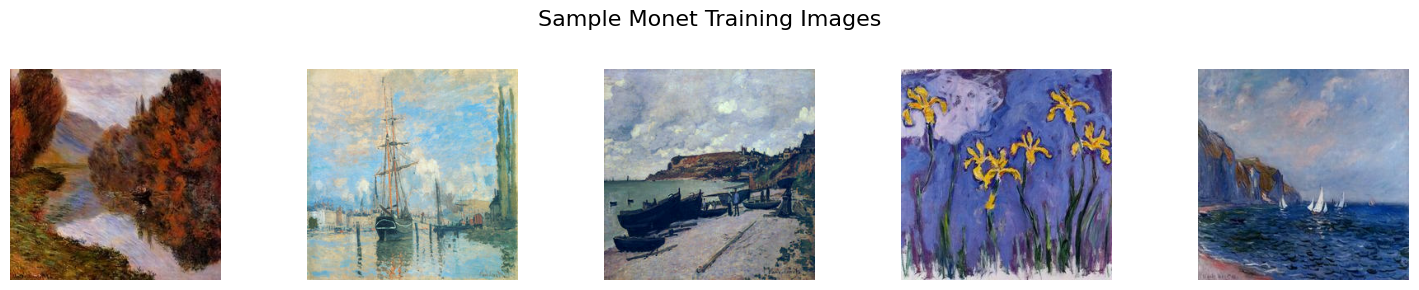

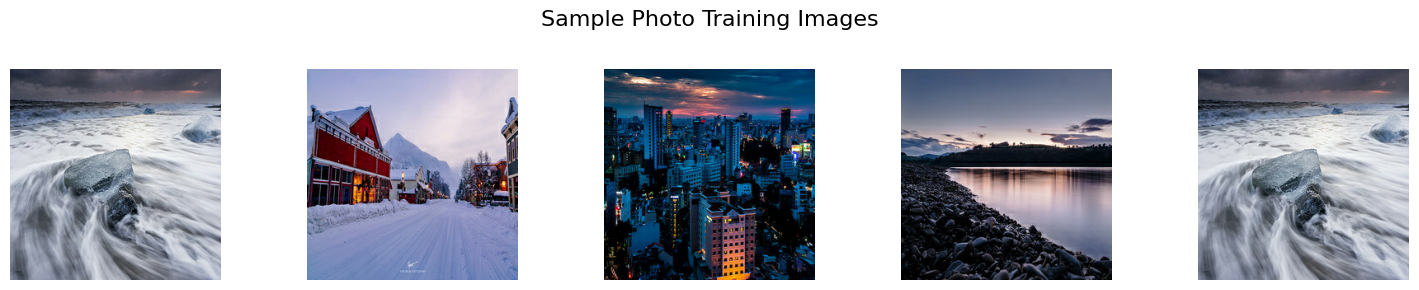

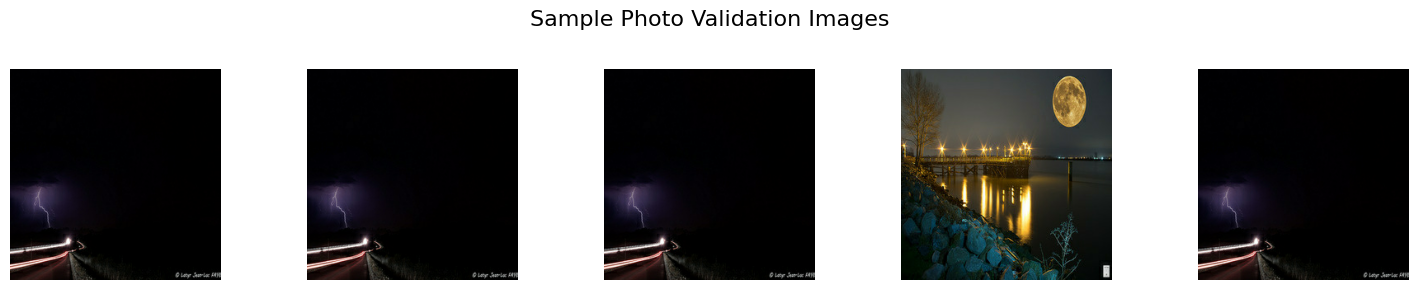

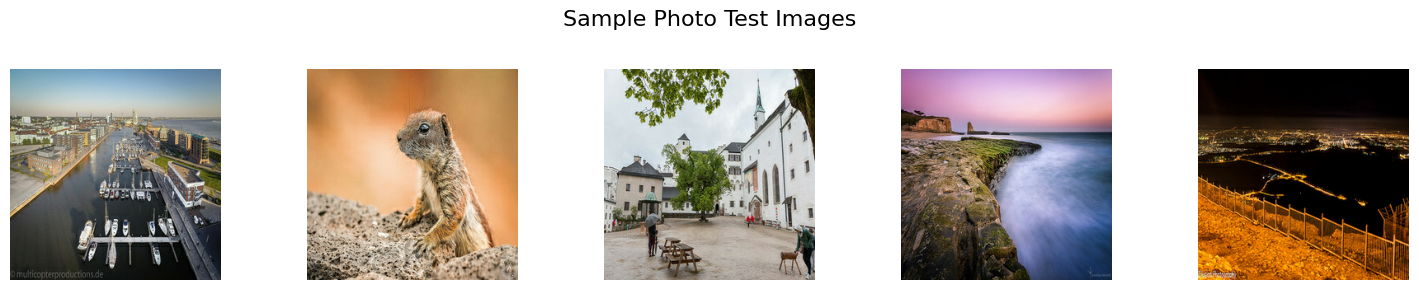

Sample images from Monet and Photo training, validation, and test datasets displayed.


In [ ]:
display_samples(monet_dataset, "Sample Monet Training Images")
display_samples(train_dataset, "Sample Photo Training Images")
display_samples(val_dataset, "Sample Photo Validation Images")
display_samples(test_dataset, "Sample Photo Test Images")
print("Sample images from Monet and Photo training, validation, and test datasets displayed.")

In [ ]:
!wandb login

wandb.init(
    project="Generate Monet paintings",
    entity="nmach22-free-university-of-tbilisi-"
)

wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nmach22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: nmach22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
